# Apply YOLO style Model For OCR

## An effectient one-shot deep detwork for OCR

After some searching, I didn't find any dataset with image+character label+ single char level bounding box。

So the most direct solution: Create a scene text detection data generator

In [1]:
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from constant import *
from constant_char import *
import numpy as np
from glob import glob
from PIL import Image

from p3self.matchbox import *
from utils import *

### Texted image generator

In [2]:

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import os
from char_data import Make_Char,rd,rd_font

# rg_n,rg_l,rg_u,rg_c,

# fonts

In [3]:
# %rm /data/forge/char_detect/*
# mc = Make_Char(img_dir = "/data/train2017/",forge_dir="/data/forge/char_detect/")
# dl = DataLoader(mc,batch_size=4,shuffle=True)
# mc_gen=iter(dl)

# from tqdm import trange
# t=trange(len(dl))

# for i in t:_ = next(mc_gen)

# pd.concat(mc.df_dicts,axis=0).to_csv("/data/forge/char_lbl.csv")

### Prepare Data

In [4]:
ann_df = pd.read_csv("/data/forge/char_lbl.csv")

ann_df.sample(5)

,Unnamed: 0,bbox,category_id,file_name,image_id
1477893,15,"[203, 260, 13, 45]",38,000000385346.jpg,000000385346.jpg
1123703,12,"[50, 194, 32, 43]",50,000000155505.jpg,000000155505.jpg
1317777,7,"[62, 104, 10, 22]",30,000000080246.jpg,000000080246.jpg
1607727,12,"[2, 254, 15, 22]",20,000000141228.jpg,000000141228.jpg
692751,3,"[1, 28, 30, 39]",6,000000441293.jpg,000000441293.jpg


In [5]:
urls = glob(IMG+"/*")

rdimg = np.random.choice(urls)
def get_id(url):
    return url.split("/")[-1]

def get_bb(rdimg):
    match = ann_df[ann_df["image_id"]==get_id(rdimg)][["bbox","category_id"]]
    return list(match["bbox"]),list(match["category_id"])

get_bb(rdimg)

(['[238, 176, 17, 35]',
  '[197, 80, 23, 38]',
  '[85, 193, 7, 45]',
  '[87, 21, 20, 34]',
  '[42, 212, 16, 21]',
  '[27, 60, 9, 25]',
  '[129, 140, 17, 32]',
  '[141, 187, 8, 19]',
  '[111, 262, 17, 43]',
  '[15, 251, 7, 17]',
  '[150, 100, 12, 33]',
  '[9, 65, 15, 19]',
  '[2, 273, 38, 44]',
  '[42, 25, 15, 16]',
  '[94, 149, 39, 46]'],
 [6, 7, 1, 8, 4, 0, 31, 11, 20, 60, 49, 58, 1104, 821, 620])

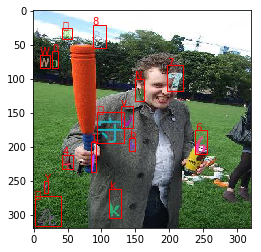

In [6]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
# %matplotlib inline

fig,ax = plt.subplots(1)
ax.imshow(Image.open(rdimg))
bbs,cids = get_bb(rdimg)
# font_label = ImageFont.FreeTypeFont("/data/fonts_cn/msyh.ttf", 5)
for i in range(len(bbs)):
    bb=eval(bbs[i])
    # format of the bb: x, y, width, height
    rect = patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    # format of bb 
    ax.text(bb[0],bb[1],idx2name[cids[i]],dict({"color":"#ff0000"}))
    # print(idx2name[cids[i]])

In [7]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

In [8]:
def df_data(ann_df,shuffle=True):
    """
    imgdf:
    A dataframe about images, fields: "id","file_name","height","width"
    ann_df:
    A dataframe about annotation, fields: "image_id","category_id","bbox",
    The field "bbox" is a list of 4 values: x,y,height, width of the bounding box
    """
    data_df=ann_df
    
    data_df["cate_id_oh"] = data_df["category_id"].apply(lambda x:idx2id[x])
    data_df["bbox"] = data_df["bbox"].apply(lambda x:eval(x))
    if shuffle:
        data_df = data_df.sample(frac=1).reset_index(drop=True)
    print("total data rows",len(data_df))
    data_df["width"] = data_df["category_id"].apply(lambda x:WIDTH)
    data_df["height"] = data_df["category_id"].apply(lambda x:HEIGHT)
    return data_df

data_df = df_data(ann_df)
data_df.head()

total data rows 2117540


,Unnamed: 0,bbox,category_id,file_name,image_id,cate_id_oh,width,height
0,19,"[228, 73, 17, 17]",654,000000220390.jpg,000000220390.jpg,654,320,320
1,9,"[47, 22, 21, 38]",54,000000515202.jpg,000000515202.jpg,54,320,320
2,0,"[204, 157, 14, 39]",8,000000307148.jpg,000000307148.jpg,8,320,320
3,1,"[127, 53, 15, 30]",6,000000365652.jpg,000000365652.jpg,6,320,320
4,8,"[120, 141, 12, 15]",22,000000281950.jpg,000000281950.jpg,22,320,320


Adjust the bounding box

In [9]:
bbox_array = np.array(data_df.bbox.tolist()).astype(np.float64)
wh_array = data_df[["width","height"]].as_matrix().astype(np.float64)

def re_calibrate(bbox_array,wh_array):
    """return the resized bbox array"""
    bb_resized = (bbox_array/np.concatenate([wh_array,wh_array],axis=-1)) *SIZE
    
    true_bb = bb_resized/SCALE
    # switch xy as left top conner to center point
    true_bb[...,:2]=true_bb[...,:2]+true_bb[...,2:]/2
    # Labels' Anchor positions on the grid map
    grid_bbxy = np.floor(true_bb[...,:2])
    return bb_resized,true_bb,grid_bbxy

def find_best_anchors(true_bbwh):
    iou_score = []
    for b in range(BOX):
        wh_anc = np.tile(ANC_ARR[b],[true_bbwh.shape[0],1])
        true_area = true_bbwh.prod(axis=-1)
        anc_area = wh_anc.prod(axis=-1)
    
        inter_area = np.min([wh_anc,true_bbwh],axis=0).prod(axis=-1)
    
        union_area = true_area + anc_area - inter_area
        iou_score.append(inter_area/union_area)
    best_anchor_idx = np.array(iou_score).T.argmax(axis=-1)
    return best_anchor_idx

bb_resized,true_bb,grid_bbxy = re_calibrate(bbox_array,wh_array)
true_bbxy,true_bbwh = true_bb[...,:2],true_bb[...,2:]
best_anchor_idx = find_best_anchors(true_bbwh)

min_lbl = SCALE * 0.001

data_df["true_bb_x"],data_df["true_bb_y"],data_df["true_bb_w"],data_df["true_bb_h"]=true_bb[:,0],true_bb[:,1],true_bb[:,2],true_bb[:,3]
data_df["true_grid_x"],data_df["true_grid_y"]=grid_bbxy[:,0],grid_bbxy[:,1]

# data_df["true_bb_x"]=data_df["true_bb_x"]-data_df["true_grid_x"]
# data_df["true_bb_y"]=data_df["true_bb_y"]-data_df["true_grid_y"]

data_df["best_anchor"]=best_anchor_idx
data_df_ = data_df[data_df["true_bb_w"]>min_lbl]
data_df_ = data_df_[data_df_["true_bb_h"]>min_lbl]


#### Reverse adjust funtion to get train labels

* t to b

$\large b_{x}=\sigma(t_{x})+c_{x}$

$\large b_{y}=\sigma(t_{y})+c_{y}$

$\large b_{w}=p_{w}e^{w}$

$\large b_{h}=p_{h}e^{h}$

* b to t

$\large t_{x}=-ln(\frac{1}{b_{x}-c_{x}}-1)$

$\large t_{y}=-ln(\frac{1}{b_{y}-c_{y}}-1)$

$\large t_{w}=ln(\frac{b_{w}}{p_{w}})$

$\large t_{h}=ln(\frac{b_{h}}{p_{h}})$

In [10]:
from conv_model import dn121_conv

dn121=dn121_conv(DN121)

In [11]:
class dn_yolo(nn.Module):
    def __init__(self,feat_extra,feat_in):
        super(dn_yolo,self).__init__()
        self.feat_in = feat_in
        self.feat_extra=feat_extra
        
        self.conv_1 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_2 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_3 = nn.Conv2d(self.feat_in,VEC_LEN*BOX,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(self.feat_in)
        self.bn2 = nn.BatchNorm2d(self.feat_in)
        self.bn3 = nn.BatchNorm2d(self.feat_in)
    
    def forward(self,x):
        
        x = self.feat_extra(x)
        
        x = self.bn1(x)
        x = self.conv_1(x)
        x = self.bn2(x)
        x = self.conv_2(x)
        x = self.bn3(x)
        x = self.conv_3(x)
        
        # from: bs,channel, height, width
        # to: bs, width, height, channel
        x = x.permute([0,3,2,1]).contiguous().view(-1,FEAT_W,FEAT_H,BOX,VEC_LEN)
        
        return x

## Data Generator

In [12]:
from torch.utils.data import DataLoader,dataset
from torchvision import transforms
from PIL import Image

In [13]:
transform = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
trans_origin = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                               ])
back2PIL = transforms.Compose([transforms.ToPILImage(mode="RGB")])

## Training

In [14]:
from torch.utils.data import DataLoader
from tqdm import trange
from datetime import datetime
import os

In [15]:
from data import Data_Multi

In [16]:
train_set = Data_Multi(data_df=data_df_,
                       transform=transform,
                       trans_origin=trans_origin)

In [17]:
trainer=Trainer(train_set,batch_size=16,print_on=5)
model = dn_yolo(dn121,1024)
from loss_ import yolo3_loss_on_t as yolo3_loss


In [18]:
# Loss function lambdas
loss_func = yolo3_loss(lbd_coord=1,
                       lbd_obj=5,
                       lbd_noobj=1,
                       lbd_cls=1,
                       testing=False,train_all=True)

In [19]:
CUDA = torch.cuda.is_available()
if CUDA:
    torch.cuda.empty_cache()
    model.cuda()
    loss_func.cuda()

In [20]:
from torch.optim import Adam
optimizer = Adam(model.parameters())

In [21]:
def action(*args,**kwargs):
    """
    y_s: label for scoring, because the y's bb has been transformed into t
    """
    x,original, t_box, conf_, cls_, mask, cls_mask, b_box = args[0]
    iteration=kwargs["ite"]
    # x,t_box, conf_, cls_, mask, cls_mask, b_box = Variable(x), Variable(t_box), Variable(conf_), Variable(cls_), Variable(mask), Variable(cls_mask), Variable(b_box)
    if CUDA:
        x,t_box, conf_, cls_, mask, cls_mask, b_box = x.cuda(),t_box.cuda(), conf_.cuda(), cls_.cuda(), mask.cuda(), cls_mask.cuda(), b_box.cuda()
    optimizer.zero_grad()
    
    y_ = model(x)
    model.x=x
    model.y_=y_
    
    loss,loss_x,loss_y,loss_w,loss_h,loss_obj,loss_noobj,loss_cls = loss_func(y_,t_box, conf_, cls_, mask, cls_mask, b_box)
    loss.backward()

    optimizer.step()

    if iteration%30==0:
        y_pred = loss_func.t2b(y_)[0:1,...]
        if CUDA:
            y_pred = y_pred.cpu()
        img = back2PIL(original[0])
        printimg = plot_bb(img,data_to_df_bmark(y_pred))
    return {"loss":loss.item(),
            "loss_x":loss_x.item(),
            "loss_y":loss_y.item(),
            "loss_w":loss_w.item(),
            "loss_h":loss_h.item(),
            "loss_obj":loss_obj.item(),
            "loss_noobj":loss_noobj.item(),
            "loss_cls":loss_cls.item(),}

trainer.action=action

In [ ]:
trainer.train(2)


  0%|          | 4/7393 [00:20<10:15:45,  5.00s/it]